# Amazon Fine Food Review Analysis

**Objective: To determine a review whether it is positive or negative
if the score is 4 or 5 it is considered as positive review and if the score is 1 or 2 it is considered as negative review whereas a score of 3 is considered as neutral and hence should not be considered.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm

C:\Users\aksha\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\aksha\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
os.chdir("D:\\applied AI\\amazon-fine-food-reviews")

In [3]:
con=sqlite3.connect("database.sqlite")
filtered_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3""",con)

def partition(x):
    if x<3:
        return 0
    return 1

actual_score=filtered_data['Score']
positive_negative=actual_score.map(partition)
filtered_data['Score']=positive_negative
#data from filtered data's score column is stored into actual score variable and then mapping our function if the actual score is >3 positve else negative and then again put this into our filtered data's score column


In [4]:
print(filtered_data.shape)
print(filtered_data.head())

(525814, 10)
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   
3                     3                       3      0  1307923200   
4                     0                       0      1  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality can

# DATA CLEANING AND PREPROCESSING

**Data Deduplication

In [5]:
duplicates=filtered_data[filtered_data.duplicated(subset=("UserId","ProfileName","Time","Summary","Text"))]
print(duplicates)

            Id   ProductId          UserId  \
29          30  B0001PB9FY  A3HDKO7OW0QNK4   
530        575  B000G6RYNE  A3PJZ8TU8FDQ1K   
2119      2310  B0001VWE0M   AQM74O8Z4FMS0   
2133      2324  B0001VWE0C   AQM74O8Z4FMS0   
2706      2947  B0002TJAZK  A2ISKAWUPGGOLZ   
2707      2948  B0002TJAZK  A3TVZM3ZIXG8YW   
3575      3886  B005GX7GVW   AS1FCKNKY95ID   
3576      3887  B005GX7GVW  A1I34N9LFOSCX7   
4269      4641  B0002NYO9I   A5DVX3B075B09   
4270      4642  B0002NYO9I  A376TWN7I4HMZ8   
4975      5398  B00622CYVS   ATIHDHZYNQ0EI   
5024      5452  B00622CYVI   ATIHDHZYNQ0EI   
5049      5477  B00622CYVI   A2MF0C4E7GYCI   
5061      5489  B00622CYVI   ASEAKR59G0SLT   
5504      5959  B001O2IX8E  A3KDZCQ82JFWLN   
5950      6442  B000QB0WUG  A16TI8YVRRC8AN   
6020      6518  B005O8BLLU   APH7I7OZ8WUJP   
6684      7322  B0042395CA   AKZKG2Z7CNV27   
7232      7900  B00126EQ8I  A3O646NL6SH3ZL   
7235      7905  B00285FFCS   ARXORJX86X1J2   
8224      8994  B006N3IG4K   A5U24

[160481 rows x 10 columns]


In [6]:
#Removing all the duplicates
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True, inplace=False, kind='quicksort', na_position='last')
#dropping the duplicate values
final=sorted_data.drop_duplicates(subset=("UserId","ProfileName","Time","Summary","Text"), keep='first',inplace= False)
final.shape

(365333, 10)

In [7]:
#percentage drop
final['Id'].size*1.0/(filtered_data['Id'].size*1.0)*100

69.4795117665182

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)

(365331, 10)


In [9]:
final['Score'].value_counts()

1    307967
0     57364
Name: Score, dtype: int64

# Text Preprocessing
**Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

**Preprocessing requires following steps :-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2
5. Convert the text in lowercase
6. Remove the stopwords
7. Finally we to stemming using snowball stemming

**After which we categories the words into positive and negative reviews

## Review Text

In [10]:
# printing some random reviews
sent_0 = final['Text'].values[31]
print(sent_0)
print("="*50)

sent_1 = final['Text'].values[43]
print(sent_1)
print("="*50)

sent_2= final['Text'].values[99]
print(sent_2)
print("="*50)


These days, when a person says, "chicken soup" they're probably going to follow up those words with, "for the soul" or maybe "for the teenaged soul".  Didn't used to be that way.  Why I can remember a time when if a person said, "chicken soup" those words were followed by an enthusiastic "with rice!".  Such was the power of Maurice Sendak's catchy 1962 children's book.  I am pleased to report that if you care to read this book again today, you will find it hasn't dimished a jot in terms of frolicksome fun.  In this book we are led through a whirlwind chicken soup year with our host, a boy who bears no little resemblance to Sendak's other great rhyming tale "Pierre" (in looks if not demeanor).  It's a catchy flouncy bouncy combo of soup and the people who love it so.<br /><br />This is ostensibly a book meant to teach your children the different months of the year.  Each month gets its own rhythmic poem and accompanying illustration.  These are fairly simple pen and ink drawings with th

**We can see that in our reviews we have some unwanted text like html tags <br></br>,- etc

In [11]:
#1- Removing URLs

# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1 = re.sub(r"http\S+", "", sent_1)
sent_2 = re.sub(r"http\S+", "", sent_2)

print(sent_0)
print("="*50)
print(sent_1)
print("="*50)
print(sent_2)
print("="*50)

These days, when a person says, "chicken soup" they're probably going to follow up those words with, "for the soul" or maybe "for the teenaged soul".  Didn't used to be that way.  Why I can remember a time when if a person said, "chicken soup" those words were followed by an enthusiastic "with rice!".  Such was the power of Maurice Sendak's catchy 1962 children's book.  I am pleased to report that if you care to read this book again today, you will find it hasn't dimished a jot in terms of frolicksome fun.  In this book we are led through a whirlwind chicken soup year with our host, a boy who bears no little resemblance to Sendak's other great rhyming tale "Pierre" (in looks if not demeanor).  It's a catchy flouncy bouncy combo of soup and the people who love it so.<br /><br />This is ostensibly a book meant to teach your children the different months of the year.  Each month gets its own rhythmic poem and accompanying illustration.  These are fairly simple pen and ink drawings with th

In [12]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
# 2-Removing decontracted words
sent_0 = decontracted(sent_0)
print(sent_0)
print("="*50)
sent_1 = decontracted(sent_1)
print(sent_1)
print("="*50)
sent_2 = decontracted(sent_2)
print(sent_2)
print("="*50)

These days, when a person says, "chicken soup" they are probably going to follow up those words with, "for the soul" or maybe "for the teenaged soul".  Did not used to be that way.  Why I can remember a time when if a person said, "chicken soup" those words were followed by an enthusiastic "with rice!".  Such was the power of Maurice Sendak is catchy 1962 children is book.  I am pleased to report that if you care to read this book again today, you will find it has not dimished a jot in terms of frolicksome fun.  In this book we are led through a whirlwind chicken soup year with our host, a boy who bears no little resemblance to Sendak is other great rhyming tale "Pierre" (in looks if not demeanor).  It is a catchy flouncy bouncy combo of soup and the people who love it so.<br /><br />This is ostensibly a book meant to teach your children the different months of the year.  Each month gets its own rhythmic poem and accompanying illustration.  These are fairly simple pen and ink drawings 

In [14]:
#3-Removing numbers

#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

These days, when a person says, "chicken soup" they are probably going to follow up those words with, "for the soul" or maybe "for the teenaged soul".  Did not used to be that way.  Why I can remember a time when if a person said, "chicken soup" those words were followed by an enthusiastic "with rice!".  Such was the power of Maurice Sendak is catchy  children is book.  I am pleased to report that if you care to read this book again today, you will find it has not dimished a jot in terms of frolicksome fun.  In this book we are led through a whirlwind chicken soup year with our host, a boy who bears no little resemblance to Sendak is other great rhyming tale "Pierre" (in looks if not demeanor).  It is a catchy flouncy bouncy combo of soup and the people who love it so.<br /><br />This is ostensibly a book meant to teach your children the different months of the year.  Each month gets its own rhythmic poem and accompanying illustration.  These are fairly simple pen and ink drawings with

In [15]:
#4- Removing Special Characters
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1 = re.sub('[^A-Za-z0-9]+', ' ', sent_1)
print(sent_1)

No waste even if she is having a day when she goes on a hunger strike she always room for one or 2 or 3 of these and the extra powder on bottom makes a real treat on food Never met a pooch that did not go crazy over her treats 


In [16]:
# 5- Remving Stopwords
s=set(stopwords.words('english'))
print(s)

{'these', 'had', 'same', 'that', 'his', "weren't", 'mightn', 'am', 'from', 'when', 'through', 'how', 'they', "that'll", "won't", 'their', 'during', 'there', 'own', 'no', 'then', "hadn't", 'won', 'him', 'because', 'did', 'been', 'to', 'as', 'once', 'not', "shan't", 'hadn', "shouldn't", 'on', 'theirs', 'its', 'ours', 'mustn', "she's", 'be', 'but', 'before', 'o', "doesn't", 'will', "couldn't", 'he', 'y', 'just', 'the', 'and', 'itself', 'here', 'who', 'other', 'haven', 'them', 'both', 's', 'shan', "wouldn't", 'can', 'between', 'only', 'all', 'under', 'themselves', 'such', 'should', 'ma', 'while', 't', 'this', 'were', 'being', 'if', 'herself', 'at', "you'd", 'you', 'll', 'd', 'ourselves', 'than', "you're", 'wouldn', 'couldn', 'yourself', 'below', 'each', 'have', 'yourselves', 'about', 'a', 'after', "don't", 'into', 'whom', 'your', 'has', 'off', 'does', "didn't", "should've", 'having', 'are', 'aren', 'me', 'our', 'is', 'where', 'so', 've', 'her', 'very', 'my', 'needn', "hasn't", 'an', 'she',

In [17]:
nltk.download('stopwords')
#https://pythonprogramming.net/stop-words-nltk-tutorial/ to learn more about stopwords
sno=nltk.stem.SnowballStemmer('english')
def cleanhtml(sentence):
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr," ",sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned=re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/|]')
    clean_ed=re.sub(cleaned," ",sentence)
    return clean_ed
print("*********************")
print(sno.stem("tasty"))

*********************
tasti


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = cleanhtml(sentance)
    sentance = decontracted(sentance)
    sentance = cleanpunc(sentance)    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in s)
    preprocessed_reviews.append(sentance.strip("'"))

100%|████████████████████████████████████████████████████████████████████████| 365331/365331 [00:51<00:00, 7092.83it/s]


In [19]:

preprocessed_reviews[10]

'get movie sound track sing along carol king great stuff whole extended family knows songs heart quality kids storytelling music'

In [20]:
final['preprocessed_reviews']=preprocessed_reviews
final.drop(['Text'], axis=1,inplace=True)

## Review Summary

In [21]:
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = cleanhtml(sentance)
    sentance = decontracted(sentance)
    sentance = cleanpunc(sentance)    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in s)
    preprocessed_summary.append(sentance.strip("'"))

100%|███████████████████████████████████████████████████████████████████████| 365331/365331 [00:19<00:00, 18450.08it/s]


In [22]:
preprocessed_summary[1]

'love book miss hard cover version'

In [23]:
final['preprocessed_summary']=preprocessed_summary
final.drop(['Summary'], axis=1,inplace=True)

In [24]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,preprocessed_reviews,preprocessed_summary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,witty little book makes son laugh loud recite ...,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,grew reading sendak books watching really rosi...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,fun way children learn months year learn poems...,chicken soup rice months


In [25]:
final.drop(columns=['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator'], inplace=True)

In [26]:
final.head(3)

,Score,Time,preprocessed_reviews,preprocessed_summary
138706,1,939340800,witty little book makes son laugh loud recite ...,every book educational
138688,1,1194739200,grew reading sendak books watching really rosi...,love book miss hard cover version
138689,1,1191456000,fun way children learn months year learn poems...,chicken soup rice months


In [75]:
final.shape

(365331, 4)

In [85]:
sample_data_1=final.sample(frac=.25)

In [86]:
sample_data_2=final.sample(frac=.10)

In [87]:
print("shape1=",sample_data_1.shape)
print("="*50)
print("shape2=",sample_data_2.shape)

shape1= (91333, 4)
shape2= (36533, 4)


In [88]:
x1=sample_data_1.iloc[:,1:4]

In [89]:
y1=sample_data_1.iloc[:,0]

In [90]:
print("shape1=",x1.shape)
print("="*50)
print("shape2=",y1.shape)

shape1= (91333, 3)
shape2= (91333,)


In [91]:
y1.value_counts(normalize=True)

1    0.842532
0    0.157468
Name: Score, dtype: float64

In [92]:
x2=sample_data_2.iloc[:,1:4]
y2=sample_data_2.iloc[:,0]

In [93]:
print("shape1=",x2.shape)
print("="*50)
print("shape2=",y2.shape)

shape1= (36533, 3)
shape2= (36533,)


In [94]:
y2.value_counts(normalize=True)

1    0.843156
0    0.156844
Name: Score, dtype: float64

In [95]:
type(y1)

pandas.core.series.Series

In [96]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train, Y_test=train_test_split(x1,y1,test_size=0.33, random_state=7)

In [97]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(61193, 3)
(30140, 3)
(61193,)
(30140,)


In [98]:
print(X_train.head(3))
print("="*50)
print(X_test.head(3))

              Time                               preprocessed_reviews  \
41525   1250380800  really love maple syrup best buying way relati...   
212163  1268352000  almond fan like like sweets well great treat h...   
475639  1310169600  save significantly buy flour bulk keep frozen ...   

                   preprocessed_summary  
41525   maple habit get expensive worth  
212163                        love nuts  
475639        perfect pasta pizza flour  
              Time                               preprocessed_reviews  \
81655   1331683200  arrived shortly ordering good stuck together f...   
211472  1299196800  apple chips taste good good 19 month old loves...   
181996  1334016000  four borzoi russian wolfhounds really like tas...   

                           preprocessed_summary  
81655                           big bag gummies  
211472  apple chips good strawberry banana much  
181996                   good quality low price  


# Featurization

### BAG OF WORDS

**What is Bag of Words?
BOW is one of the techniques to convert our text(whether its a summary or a review) into its equivalent vectors and after converting it into vector form we can perform all the linear algebra computation to it.

In [99]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train['preprocessed_reviews'])
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_train = count_vect.transform(X_train["preprocessed_reviews"])
print(type(final_counts_train))
print(final_counts_train.shape)
print(final_counts_train[5,0])
print('='*50)
final_counts_test=count_vect.transform(X_test['preprocessed_reviews'])
print(type(final_counts_test))
print(final_counts_test.shape)
print(final_counts_test[5,0])

some feature names  ['00', '000', '000001', '00001', '0003', '000mg', '001', '00a', '00am', '00pm']
<class 'scipy.sparse.csr.csr_matrix'>
(61193, 46851)
0
<class 'scipy.sparse.csr.csr_matrix'>
(30140, 46851)
0


In [100]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train['preprocessed_summary'])
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_train_summary = count_vect.transform(X_train['preprocessed_summary'])
print(type(final_train_summary))
print(final_train_summary.shape)
print(final_train_summary[5,0])
print('='*50)
final_test_summary = count_vect.transform(X_test['preprocessed_summary'])
print(type(final_test_summary))
print(final_test_summary.shape)
print(final_test_summary[5,0])
print('='*50)

some feature names  ['00', '000', '00g', '00pm', '02', '05', '05oz', '0625', '0631', '09']
<class 'scipy.sparse.csr.csr_matrix'>
(61193, 13278)
0
<class 'scipy.sparse.csr.csr_matrix'>
(30140, 13278)
0


In [101]:
Y_train.value_counts()

1    51459
0     9734
Name: Score, dtype: int64

**to read more about regular expression go to https://www.pythonforbeginners.com/regex/regular-expressions-in-python

### Bi-Grams And N-Grams 

In [28]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (365331, 5000)
the number of unique words including both unigrams and bigrams  5000


In [29]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_summary)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (365331, 5000)
the number of unique words including both unigrams and bigrams  5000


### TF-IDF(term frequency-inverse document frequency)


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf_review = vectorizer.fit_transform(preprocessed_reviews)
print("Shape of matrix ",text_tfidf_review.shape)

Shape of matrix  (365331, 23667)


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf_summary = vectorizer.fit_transform(preprocessed_summary)
print("Shape of matrix ",text_tfidf_summary.shape)

Shape of matrix  (365331, 5967)


In [30]:
total=preprocessed_reviews+ preprocessed_summary

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10) #df tells us that we will only consider those words which is present atleast in 10 documents
text_tfidf_total = vectorizer.fit_transform(total)
print("Shape of matrix  ",text_tfidf_total.shape)

Shape of matrix   (730662, 24603)


### avgWord2Vec

In [32]:
#https://stackoverflow.com/questions/49083826/get-trouble-to-load-glove-840b-300d-vector
import os 
os.chdir("D:\\applied AI\\Donorchoose")

import numpy as np
from tqdm import tqdm
#from tqdm import tqdm_notebook as tqdm
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding='utf8')
    model = {}
    for line in tqdm(f):
        splitLine = line.split(' ')
        word = splitLine[0]
        embedding = np.asarray(splitLine[1:], dtype='float32')
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model

In [33]:
model = loadGloveModel('glove.840B.300d.txt')

Loading Glove Model


2196017it [09:46, 3746.49it/s]


Done. 2196016  words loaded!


In [34]:
words = []
for i in total:
    words.extend(i.split(' ')) #The extend() extends the list by adding all items of a list (passed as an argument) to the end. 

    
    

print("all the words in the corpus", len(words))
words = set(words)
print("the unique words in the corpus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our corpus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_corpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_corpus[i] = model[i]
print("word 2 vec length", len(words_corpus))

all the words in the corpus 15498849
the unique words in the corpus 179156
The number of words that are present in both glove vectors and our corpus 88788 ( 49.559 %)
word 2 vec length 88788


In [35]:
import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_corpus, f) # save training datasets into a pickle file for machine learning


In [36]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [37]:
# compute average word2vec for all the text ie summary+review

from tqdm import tqdm_notebook as tqdm
avg_w2v_vectors = []; # the avg-w2v for each essays is stored in this list
for sentence in tqdm(total): # for each essay
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a esssay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))


730662
300


## TF-idf weighted word2vec

In [38]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(total)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [39]:
from tqdm import tqdm_notebook as tqdm
tfidf_w2v_vectors = []; # the avg-w2v for each sentence
for sentence in tqdm(total): # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))


730662
300


# Applying TSNE

## 6.1 tsne with BOW

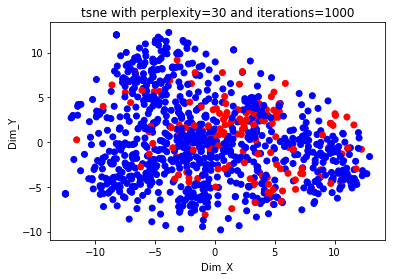

In [63]:
#taking only 5000 datapoints
#coo_matrix' object is not subscriptable-> https://stackoverflow.com/questions/30163830/accessing-elements-in-coo-matrix
#https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/2904/code-example-of-t-sne/2/module-2-data-science-exploratory-data-analysis-and-data-visualization
#series has no object as reshape-> https://stackoverflow.com/questions/53723928/attributeerror-series-object-has-no-attribute-reshape
from sklearn.manifold import TSNE
import seaborn as sn
X=final_counts[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0)
#no of components=2
#learning rate=200
#default perplexity=30
#default number of iterations=1000
X_embedding=model.fit_transform(X.toarray())

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=30 and iterations=1000")
plt.show()

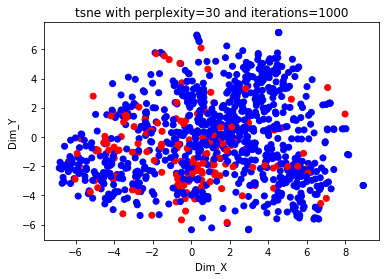

In [73]:
#taking only 5000 datapoints
#coo_matrix' object is not subscriptable-> https://stackoverflow.com/questions/30163830/accessing-elements-in-coo-matrix
#https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/2904/code-example-of-t-sne/2/module-2-data-science-exploratory-data-analysis-and-data-visualization
#series has no object as reshape-> https://stackoverflow.com/questions/53723928/attributeerror-series-object-has-no-attribute-reshape
from sklearn.manifold import TSNE
import seaborn as sn
X=final_counts[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=50)
#no of components=2
#learning rate=200
#default perplexity=50
#default number of iterations=1000
X_embedding=model.fit_transform(X.toarray())

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=30 and iterations=1000")
plt.show()

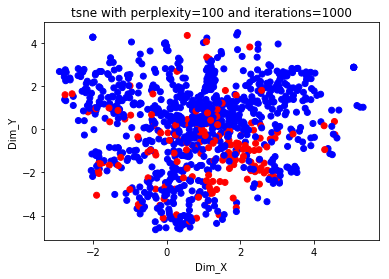

In [74]:
#taking only 5000 datapoints
#coo_matrix' object is not subscriptable-> https://stackoverflow.com/questions/30163830/accessing-elements-in-coo-matrix
#https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/2904/code-example-of-t-sne/2/module-2-data-science-exploratory-data-analysis-and-data-visualization
#series has no object as reshape-> https://stackoverflow.com/questions/53723928/attributeerror-series-object-has-no-attribute-reshape
from sklearn.manifold import TSNE
import seaborn as sn
X=final_counts[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=100)
#no of components=2
#learning rate=200
#default perplexity=100
#default number of iterations=1000
X_embedding=model.fit_transform(X.toarray())

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=100 and iterations=1000")
plt.show()

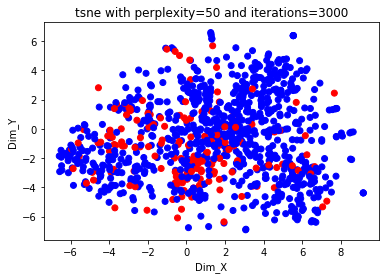

In [76]:
from sklearn.manifold import TSNE
import seaborn as sn
X=final_counts[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=50, n_iter=3000)
#no of components=2
#learning rate=200
#default perplexity=50
#default number of iterations=3000
X_embedding=model.fit_transform(X.toarray())

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=3000")
plt.show()

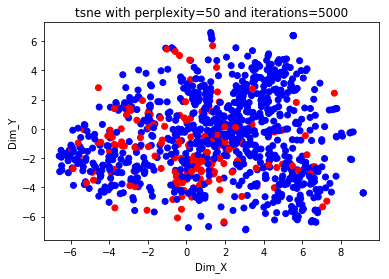

In [77]:
from sklearn.manifold import TSNE
import seaborn as sn
X=final_counts[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=50, n_iter=5000)
#no of components=2
#learning rate=200
#default perplexity=50
#default number of iterations=5000
X_embedding=model.fit_transform(X.toarray())

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=5000")
plt.show()

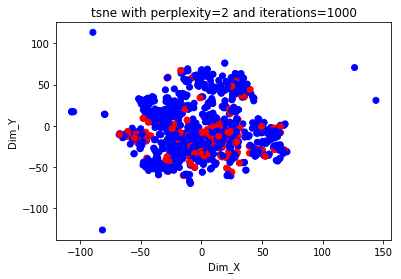

In [78]:
from sklearn.manifold import TSNE
import seaborn as sn
X=final_counts[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=2)
#no of components=2
#learning rate=200
#default perplexity=2
#default number of iterations=1000
X_embedding=model.fit_transform(X.toarray())

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=2 and iterations=1000")
plt.show()

## 6.1 tsne with T-idf 

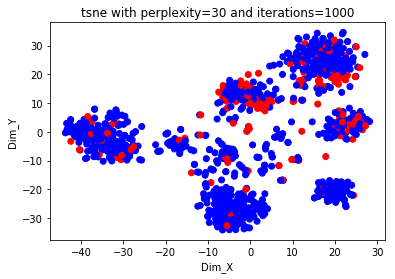

In [79]:
from sklearn.manifold import TSNE
import seaborn as sn
X=text_tfidf_total[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=30, n_iter=1000)
#no of components=2
#learning rate=200
#default perplexity=30
#default number of iterations=5000
X_embedding=model.fit_transform(X.toarray())

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=30 and iterations=1000")
plt.show()

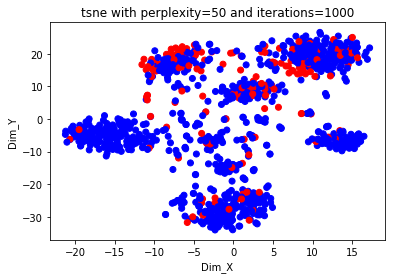

In [80]:
from sklearn.manifold import TSNE
import seaborn as sn
X=text_tfidf_total[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=50, n_iter=1000)
#no of components=2
#learning rate=200
#default perplexity=50
#default number of iterations=1000
X_embedding=model.fit_transform(X.toarray())

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=1000")
plt.show()

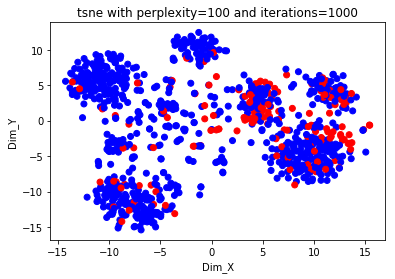

In [81]:
from sklearn.manifold import TSNE
import seaborn as sn
X=text_tfidf_total[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=100, n_iter=1000)
#no of components=2
#learning rate=200
#default perplexity=100
#default number of iterations=1000
X_embedding=model.fit_transform(X.toarray())

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=100 and iterations=1000")
plt.show()

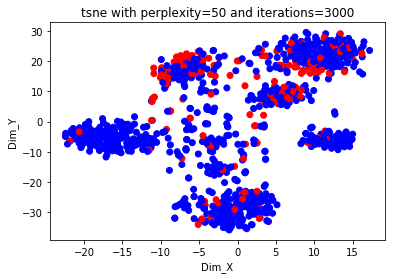

In [82]:
from sklearn.manifold import TSNE
import seaborn as sn
X=text_tfidf_total[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=50, n_iter=3000)
#no of components=2
#learning rate=200
#default perplexity=50
#default number of iterations=3000
X_embedding=model.fit_transform(X.toarray())

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=3000")
plt.show()

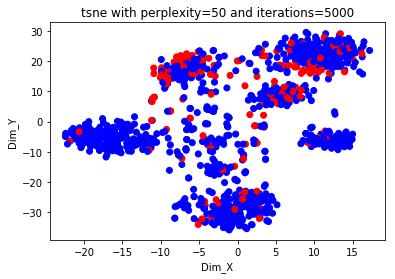

In [83]:
from sklearn.manifold import TSNE
import seaborn as sn
X=text_tfidf_total[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=50, n_iter=5000)
#no of components=2
#learning rate=200
#default perplexity=50
#default number of iterations=5000
X_embedding=model.fit_transform(X.toarray())

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=5000")
plt.show()

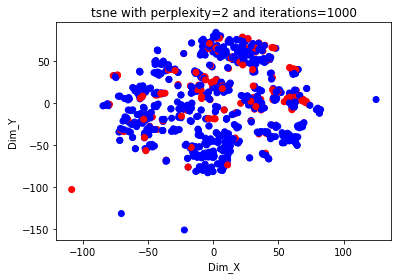

In [84]:
from sklearn.manifold import TSNE
import seaborn as sn
X=text_tfidf_total[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=2, n_iter=1000)
#no of components=2
#learning rate=200
#default perplexity=2
#default number of iterations=1000
X_embedding=model.fit_transform(X.toarray())

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=2 and iterations=1000")
plt.show()

## Average word2vec

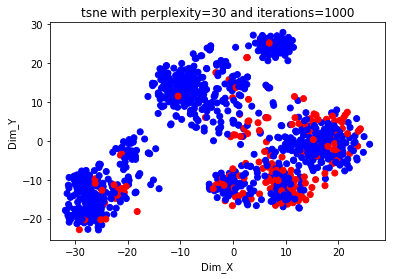

In [87]:
from sklearn.manifold import TSNE
import seaborn as sn
X=avg_w2v_vectors[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=30, n_iter=1000)
#no of components=2
#learning rate=200
#default perplexity=30
#default number of iterations=5000
X_embedding=model.fit_transform(X)

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=30 and iterations=1000")
plt.show()

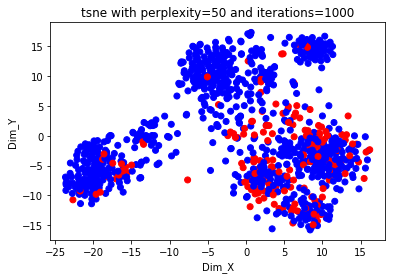

In [88]:
X=avg_w2v_vectors[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=50, n_iter=1000)
#no of components=2
#learning rate=200
#default perplexity=50
#default number of iterations=5000
X_embedding=model.fit_transform(X)

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=1000")
plt.show()

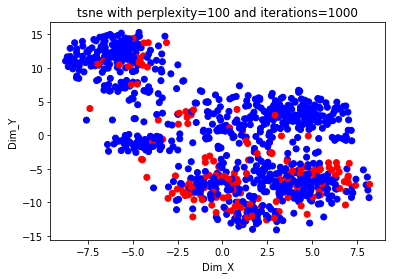

In [89]:
X=avg_w2v_vectors[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=100, n_iter=1000)
#no of components=2
#learning rate=200
#default perplexity=100
#default number of iterations=5000
X_embedding=model.fit_transform(X)

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=100 and iterations=1000")
plt.show()

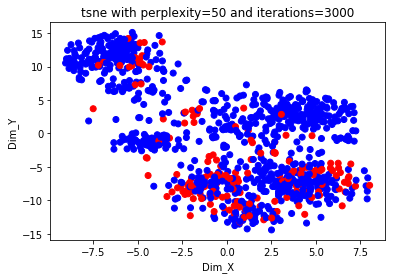

In [91]:
X=avg_w2v_vectors[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=100, n_iter=3000)
#no of components=2
#learning rate=200
#default perplexity=50
#default number of iterations=3000
X_embedding=model.fit_transform(X)

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=3000")
plt.show()

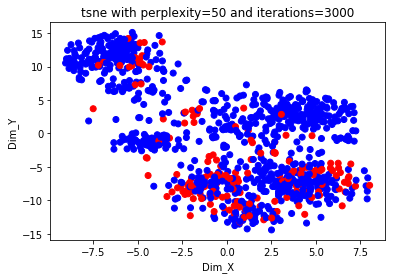

In [92]:
X=avg_w2v_vectors[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=100, n_iter=5000)
#no of components=2
#learning rate=200
#default perplexity=50
#default number of iterations=3000
X_embedding=model.fit_transform(X)

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=3000")
plt.show()

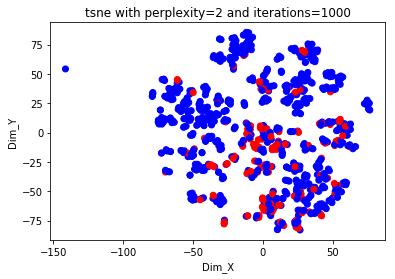

In [93]:
from sklearn.manifold import TSNE
import seaborn as sn
X=avg_w2v_vectors[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=2, n_iter=1000)
#no of components=2
#learning rate=200
#default perplexity=2
#default number of iterations=1000
X_embedding=model.fit_transform(X)

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=2 and iterations=1000")
plt.show()

## weighted average word2vec

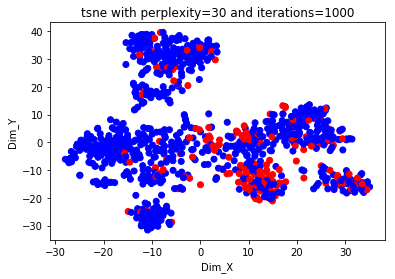

In [95]:
from sklearn.manifold import TSNE
import seaborn as sn
X=tfidf_w2v_vectors[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=30, n_iter=1000)
#no of components=2
#learning rate=200
#default perplexity=30
#default number of iterations=5000
X_embedding=model.fit_transform(X)

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=30 and iterations=1000")
plt.show()

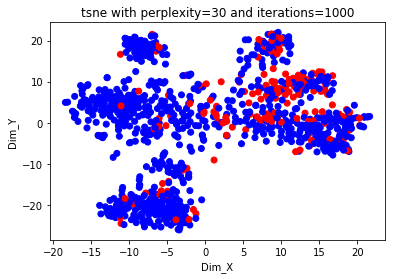

In [96]:
from sklearn.manifold import TSNE
import seaborn as sn
X=tfidf_w2v_vectors[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=50, n_iter=1000)
#no of components=2
#learning rate=200
#default perplexity=30
#default number of iterations=5000
X_embedding=model.fit_transform(X)

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=30 and iterations=1000")
plt.show()

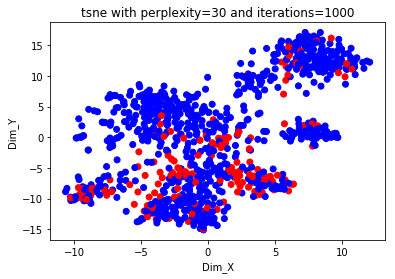

In [97]:
from sklearn.manifold import TSNE
import seaborn as sn
X=tfidf_w2v_vectors[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=100, n_iter=1000)
#no of components=2
#learning rate=200
#default perplexity=30
#default number of iterations=5000
X_embedding=model.fit_transform(X)

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=30 and iterations=1000")
plt.show()

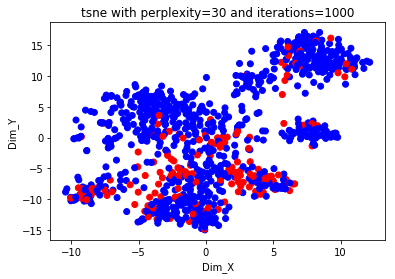

In [98]:
from sklearn.manifold import TSNE
import seaborn as sn
X=tfidf_w2v_vectors[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=100, n_iter=3000)
#no of components=2
#learning rate=200
#default perplexity=30
#default number of iterations=5000
X_embedding=model.fit_transform(X)

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=30 and iterations=1000")
plt.show()

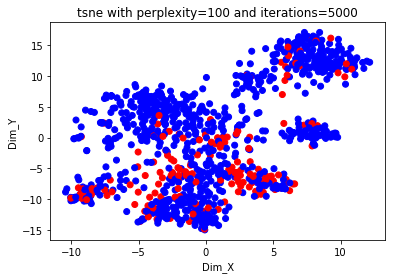

In [99]:
from sklearn.manifold import TSNE
import seaborn as sn
X=tfidf_w2v_vectors[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=100, n_iter=5000)
#no of components=2
#learning rate=200
#default perplexity=30
#default number of iterations=5000
X_embedding=model.fit_transform(X)

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=100 and iterations=5000")
plt.show()

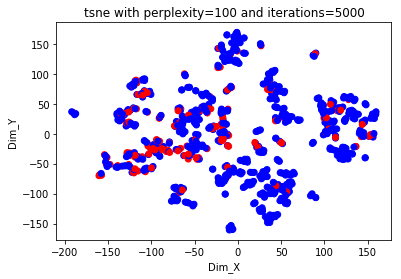

In [100]:
from sklearn.manifold import TSNE
import seaborn as sn
X=tfidf_w2v_vectors[0:1000:]
Y=final['Score'][0:1000]
model=TSNE(n_components=2,random_state=0,perplexity=2, n_iter=5000)
#no of components=2
#learning rate=200
#default perplexity=30
#default number of iterations=5000
X_embedding=model.fit_transform(X)

for_tsne = np.hstack((X_embedding, Y.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'blue'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=100 and iterations=5000")
plt.show()